In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import brewer2mpl
from cycler import cycler
import matplotlib.pyplot as plt
import pandas as pd
import prettyplotlib as ppl
import numpy as np
import scipy.stats as stats
import scipy
from scipy import signal
from scipy.optimize import curve_fit
from sklearn.neighbors import KernelDensity
from sklearn.grid_search import GridSearchCV
from matplotlib import rc
set2 = brewer2mpl.get_map('Dark2', 'qualitative', 8).mpl_colors
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman'], 'size':14})
rc('text', usetex=True)
rc('lines', linewidth=2)
rc('axes', prop_cycle=cycler('color', set2))

In [2]:
def get_pseudo_pdf(big_grid, data, bmin=0.01, bmax=0.2, normed = False):
    grid = GridSearchCV(KernelDensity(),
                        {'bandwidth': np.linspace(bmin, bmax, 100)},
                        cv=len(data) - 1)
    grid.fit(data[:,None])

    kde = grid.best_estimator_
    pseudo_pdf = np.exp(kde.score_samples(big_grid[:, None]))
    
    if normed:
        pseudo_pdf /= sum(pseudo_pdf)
    return pseudo_pdf, kde

In [3]:
df = pd.read_csv('final_data_files/uncrowded_everything_m4_clipped.csv')
df_ab = df[df.type == 0]
df_c = df[df.type == 1]

resid_finite = np.isfinite(df_ab.resid_m4_3.values)
resid3 = df_ab.resid_m4_3.values[resid_finite]
merr3 = df_ab.merr_3.values[resid_finite]

spect_finite = np.isfinite(df.spectfeh.values)
spectfeh = df.spectfeh.values[spect_finite]
meanfeh = spectfeh.mean()
spectfeh -= meanfeh

spect_finite_2 = np.isfinite(df_ab.spectfeh.values)

spect_resid = df_ab.spectfeh.values[spect_finite_2 & resid_finite]
mean_feh_resid = spect_resid.mean()
spect_resid -= mean_feh_resid

delta = 1e-4
big_grid = np.arange(-1,1,delta)

In [4]:
# get the not-actually-pdfs for the residuals and metallicity

obs_pdf, obs_kde = get_pseudo_pdf(big_grid, resid3)
feh_pdf, feh_kde = get_pseudo_pdf(big_grid, spectfeh)
feh_pdf_trim, feh_kde_trim = get_pseudo_pdf(big_grid, spect_resid)
errscale = np.median(merr3)

meanfeh_diff = meanfeh - mean_feh_resid

In [14]:
print errscale, full_width_of_PL

0.0460452590023 0.12124355653


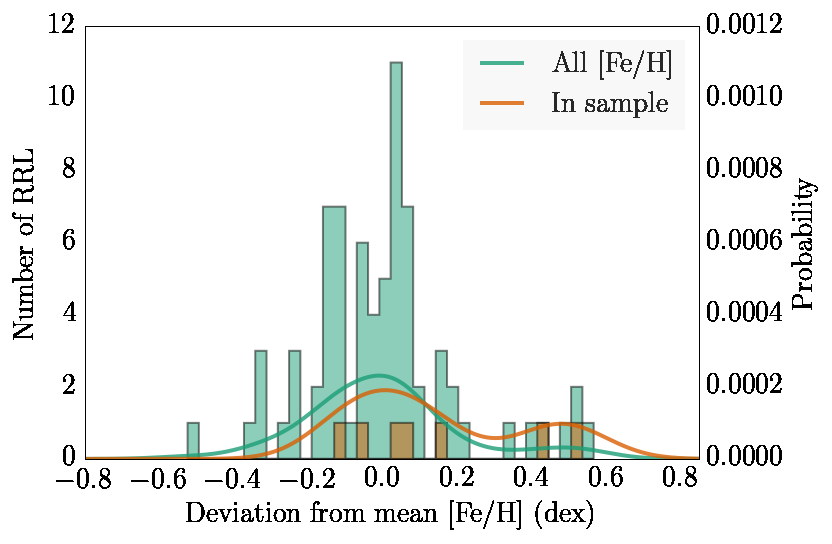

In [64]:
histbins = np.linspace(spectfeh.min(), spectfeh.max(), len(spectfeh) / 2.)

fig, ax = plt.subplots()
ax2 = ax.twinx()
ppl.plot(ax2, big_grid, feh_pdf/sum(feh_pdf), color=set2[0], alpha=0.8,
         linewidth=2, label='All [Fe/H]')
n,b,p=ax.hist(spectfeh, histbins, fc=set2[0], histtype='stepfilled', alpha=0.5)
ppl.plot(ax,[],[])
ax2.plot(big_grid - meanfeh_diff, feh_pdf_trim/sum(feh_pdf_trim), color=set2[1], 
        alpha=0.8, label='In sample')
ax.hist(spect_resid - meanfeh_diff, histbins, fc=set2[1], histtype='stepfilled', alpha=0.5)
ppl.legend(loc='best', prop={'size':14})
ax.set_xlabel('Deviation from mean [Fe/H] (dex)')
ax.set_ylabel('Number of RRL')
ax2.set_ylabel('Probability')
ax2.set_ylim(0, 12 / sum(feh_pdf))
#plt.vlines(0,0,10,'k',linestyle='--',linewidth=0.75)
plt.xlim(-0.8,0.85)
fig.tight_layout()
fig.savefig('final_plots/feh_distribution.pdf')


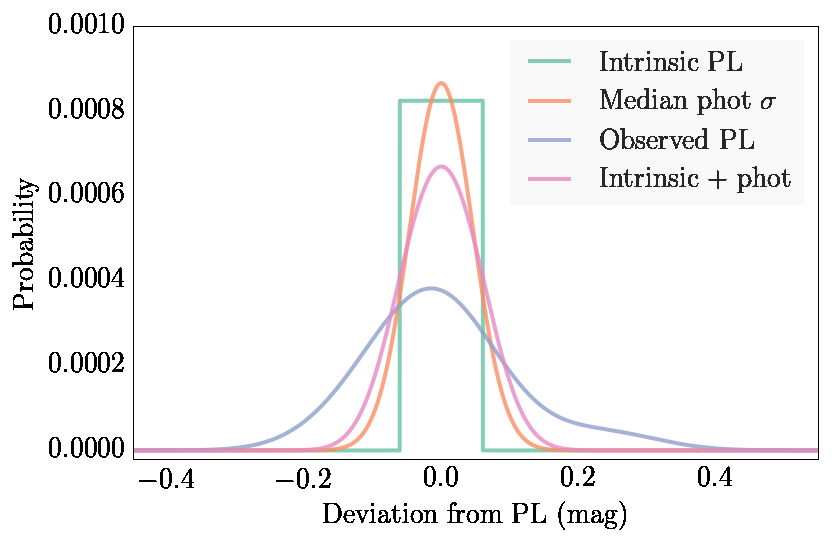

In [6]:
full_width_of_PL = np.sqrt(12.)*0.035
center_of_PL = -full_width_of_PL / 2
intrinsic = stats.uniform(loc=center_of_PL,scale=full_width_of_PL)
photometric = stats.norm(loc=0,scale=errscale)

## Setting up the PDFs and PMFs for the components
pmf_o = obs_pdf*delta
pmf_i = intrinsic.pdf(big_grid)*delta
pmf_p = photometric.pdf(big_grid)*delta

#convolve 
conv_pmf = scipy.signal.fftconvolve(pmf_i,pmf_p,'same')
conv_pmf = conv_pmf/sum(conv_pmf)

fig = plt.figure()
ppl.plot(big_grid,pmf_i, label='Intrinsic PL', linewidth=2, alpha=0.8)
plt.plot(big_grid,pmf_p, label='Median phot $\sigma$', alpha=0.8)
plt.plot(big_grid,pmf_o, label='Observed PL', alpha=0.8)
plt.plot(big_grid,conv_pmf, label='Intrinsic + phot', alpha=0.8)
ppl.legend(prop={'size':14})
#plt.suptitle('Observed PL relation and known components')
plt.ylim(-0.00002,0.001)
plt.xlim(-0.45,0.55)
plt.xlabel('Deviation from PL (mag)')
plt.ylabel('Probability')
fig.tight_layout()
fig.savefig('final_plots/distributions_nofeh.pdf')

In [7]:
# so we divide big_grid by a scale factor to force the metallicity distribution
# to fit within the observed distribution
# this is essentially the same as changing the width of a gaussian
# i really can't explain rigorously why this works but it does

# this gets the pseudo-pdf for the rescaled metallicity distribution

def get_pmf_m(big_grid, scale):
    big_grid_scaled = big_grid/scale
    resampled_pdf_feh = np.exp(feh_kde_trim.score_samples(big_grid_scaled[:, None]))
    pmf_m = resampled_pdf_feh / sum(resampled_pdf_feh)
    return pmf_m

In [8]:
# this convolves the metallicity distribution with the previous convolution
# of the intrinsic distribution and photometric errors

def get_convolved_m(big_grid, scale):
    pmf_m = get_pmf_m(big_grid, scale)
    metallicity_convolved = scipy.signal.fftconvolve(conv_pmf, pmf_m, 'same')
    metallicity_convolved = metallicity_convolved/sum(metallicity_convolved)
    return metallicity_convolved

In [9]:
# this may be the worst fitting a thing to a thing I have ever done
# optimize the scale factor on this shit

popt, pcov = curve_fit(get_convolved_m, big_grid, pmf_o, p0 = 0.5)
print popt, pcov

[ 0.32868397] [[  1.67124371e-07]]


In [10]:
pmf_m = get_pmf_m(big_grid, popt[0])
metallicity_convolved = get_convolved_m(big_grid, popt[0])

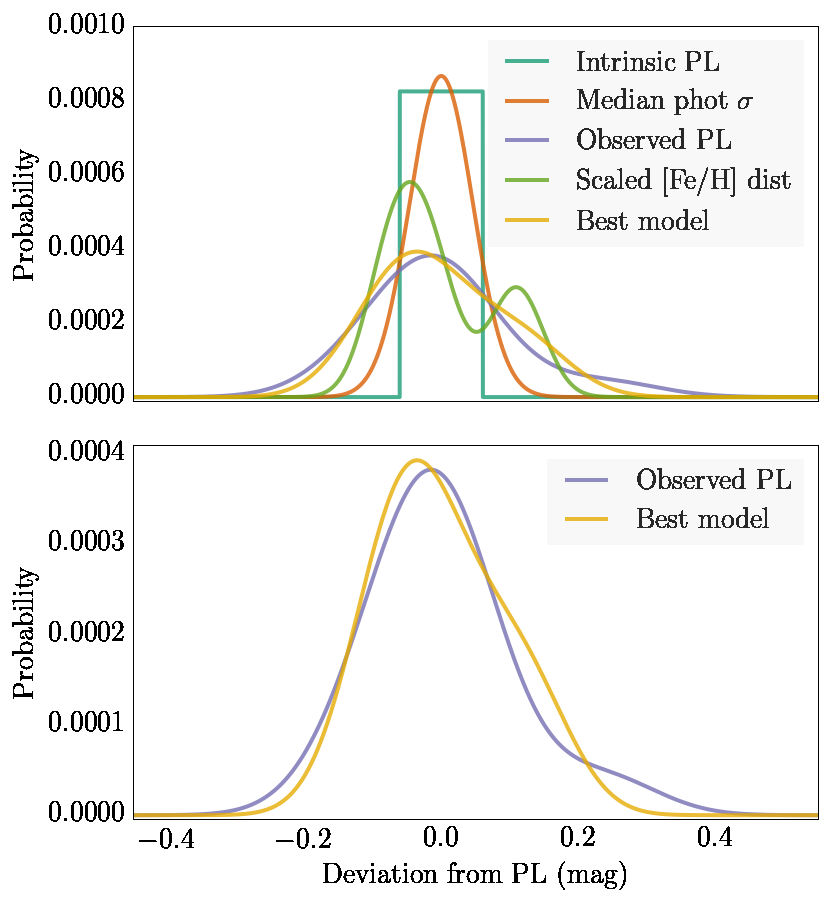

In [11]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(6,6.5), sharex=True)

ppl.plot(ax1, big_grid,pmf_i, label='Intrinsic PL', linewidth=2, alpha=0.8)
ax1.plot(big_grid,pmf_p, label='Median phot $\sigma$', alpha=0.8)
ax1.plot(big_grid,pmf_o, label='Observed PL', alpha=0.8)
ax1.plot(big_grid,conv_pmf, alpha=0.)
ax1.plot(big_grid,pmf_m, label="Scaled [Fe/H] dist", alpha=0.8)
ax1.plot(big_grid,metallicity_convolved, label="Best model", alpha=0.8)

ppl.plot(ax2, big_grid,pmf_o, label='Observed PL', color=set2[2], linewidth=2, alpha=0.8)
ax2.plot(big_grid,metallicity_convolved, label="Best model", color=set2[5], alpha=0.8)

ax2.set_xlabel('Deviation from PL (mag)')
ax1.set_ylabel('Probability')
ax2.set_ylabel('Probability')

#title_text = 'Best fit metallicity model, scale factor = {:.3f}'.format(popt[0])
ppl.legend(ax1, loc='best', prop={'size':14})
ppl.legend(ax2, loc='best', prop={'size':14})
#plt.suptitle(title_text)
ax1.set_xlim(-0.45,0.55)
ylim = np.array([-0.00001, 0.001])
ax1.set_ylim(ylim)
ax2.set_ylim(ylim * 0.41)
fig.tight_layout()
fig.savefig('final_plots/distributions.pdf')

In [12]:
from IPython.display import Image
from IPython.display import display
display(Image(url='http://i.imgur.com/vLYLQ.gif'))

In [13]:
# soooooooooooooo what does this...mean
# how do we quantify "the metallicity contributes x to the scatter" from here